In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
import networkx as nx 
from sklearn.ensemble import RandomForestClassifier
from time import strftime, gmtime

%matplotlib inline

In [2]:
def describe_data(serie: pd.Series, title, nb_bins=None, kde=True, figsize=(10, 6)) -> pd.DataFrame:
    """ Returns describe and plots of the Serie: plots are a boxplot and a histogram

    :type kde: bool
    :type nb_bins: int
    :type title: str
    :type serie: pd.Series
    :param serie: serie to be described
    :param title: title of the figure
    :param nb_bins: nb of bins of hist
    :param kde: wether or not to put a contour line in the hist
    :return: described dataframe with plots
    """
    if type(serie) != pd.core.series.Series:
        raise TypeError('serie must be a pd.Series not {}'.format(type(serie)))
    df = pd.DataFrame(data=serie)
    f, axes = plt.subplots(1, 2, figsize=figsize)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.boxplot(data=df, ax=axes[0])
    sns.distplot(df, color="b", kde=kde, ax=axes[1], bins=nb_bins)
    plt.tight_layout()
    plt.grid(True)
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    return df.describe().T


def pairwise_plot(df: pd.DataFrame) -> pd.DataFrame:
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.pairplot(df)
    plt.suptitle('Pairwise plot', fontsize=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    return df.corr(method='spearman')


def regression_plot(df: pd.DataFrame, col1: str, col2: str, title: str, figsize=(7, 5)):
    """
    ScatterPlot data give dataframe df, col1 name, col2 name, title, and a linear regression model fit
    return spearman corrrelation by default
    """
    correlation_pearson = df[[col1, col2]].corr(method='pearson').iloc[0, 1]
    correlation_spearman = df[[col1, col2]].corr(method='spearman').iloc[0, 1]
    f, axes = plt.subplots(1, 1, figsize=figsize)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.regplot(df[col1], df[col2], scatter_kws={'s': 3, 'color': 'blue'}, line_kws={'color': 'red'}, ax=axes)
    f.suptitle(title)
    plt.show()

    print('Pearson correlation coefficient is: {:.2}   \n'.format(correlation_pearson))
    print('Spearman correlation coefficient is: {:.2}   \n'.format(correlation_spearman))

    return correlation_pearson, correlation_spearman


def check_array(array: np.array) -> None:
    if not isinstance(array, np.ndarray):
        raise TypeError('array must be an array not a {}'.format(type(array)))

        
def check_dataframe(df: pd.DataFrame) -> None:
    if not isinstance(df, pd.DataFrame):
        raise TypeError('df must be a df not a {}'.format(type(df)))

        
def check_serie(serie: pd.Series) -> None:
    if not isinstance(serie, pd.Series):
        raise TypeError('serie must be a serie not a {}'.format(type(serie)))

#### (6 points) Explore the data and report some descriptive statistics (e.g., use df.describe(), report the number of classes, summarize the attack and defense distributions, etc.). This will be useful later in your analysis.

In [3]:
pokemons = pd.read_csv('pokemon.csv', index_col=0)
pokemons.head()

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
pid,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [4]:
combats = pd.read_csv('combats.csv')
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [5]:
pokemons.dtypes

Name         object
Class 1      object
Class 2      object
HP            int64
Attack        int64
Defense       int64
Sp. Atk       int64
Sp. Def       int64
Speed         int64
Legendary      bool
dtype: object

In [6]:
# quantify NaNs for each column: too many for class 2.. this feature cannot be used!
pokemons.isna().sum()

Name           1
Class 1        0
Class 2      386
HP             0
Attack         0
Defense        0
Sp. Atk        0
Sp. Def        0
Speed          0
Legendary      0
dtype: int64

In [7]:
pokemons[pokemons.isnull().any(axis=1)].head(3)

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
pid,,,,,,,,,,
5,Charmander,Fire,NaN,39,52,43,60,50,65,False
6,Charmeleon,Fire,NaN,58,64,58,80,65,80,False
10,Squirtle,Water,NaN,44,48,65,50,64,43,False


In [8]:
combats.dtypes

First_pokemon     int64
Second_pokemon    int64
Winner            int64
dtype: object

In [9]:
# quantify NaNs for each column
combats.isna().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

In [10]:
# number of classes
classes = len(set(pokemons['Class 1'].unique().tolist() + pokemons['Class 2'].unique().tolist()))
print("There are {} classes for pokemons".format(classes))

There are 19 classes for pokemons


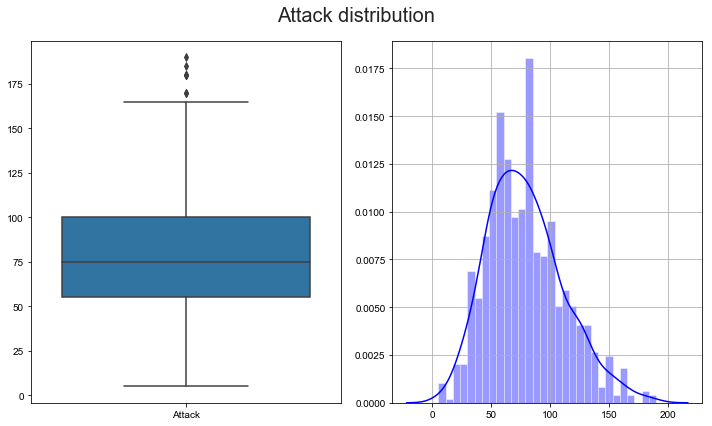

,count,mean,std,min,25%,50%,75%,max
Attack,800.0,79.00125,32.457366,5.0,55.0,75.0,100.0,190.0


In [11]:
# summarize the attack distribution
describe_data(pokemons['Attack'], 'Attack distribution', nb_bins=30)

**Attack distribution** has a large standard deviation ~33, with values ranging from 5 to 190. The median is at 75. 

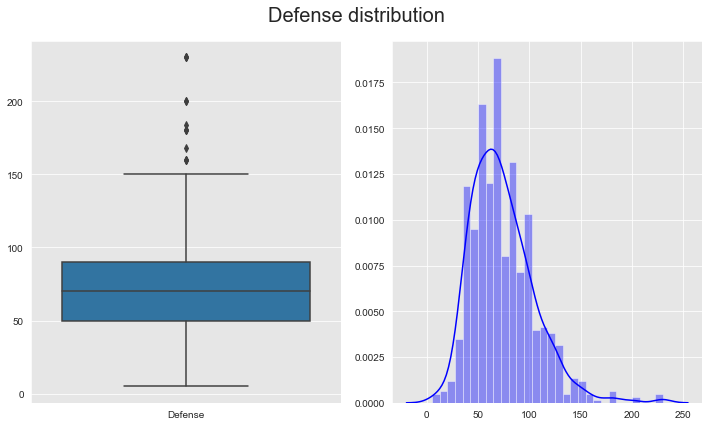

,count,mean,std,min,25%,50%,75%,max
Defense,800.0,73.8425,31.183501,5.0,50.0,70.0,90.0,230.0


In [12]:
# summarize defense distribution
describe_data(pokemons['Defense'], 'Defense distribution', nb_bins=30)

**Defense distribution** has a large standard deviation ~32, with values ranging from 5 to 230. The median is at 70 while the mean is at 73. Boxplot shows a lot of outliers.  

In [13]:
pokemons.describe().T

,count,mean,std,min,25%,50%,75%,max
HP,800.0,69.25875,25.534669,1.0,50.00,65.0,80.0,255.0
Attack,800.0,79.00125,32.457366,5.0,55.00,75.0,100.0,190.0
Defense,800.0,73.84250,31.183501,5.0,50.00,70.0,90.0,230.0
Sp. Atk,800.0,72.82000,32.722294,10.0,49.75,65.0,95.0,194.0
Sp. Def,800.0,71.90250,27.828916,20.0,50.00,70.0,90.0,230.0
Speed,800.0,68.27750,29.060474,5.0,45.00,65.0,90.0,180.0


In [14]:
combats.describe().T

,count,mean,std,min,25%,50%,75%,max
First_pokemon,50000.0,400.49564,229.549429,1.0,203.0,399.0,597.25,800.0
Second_pokemon,50000.0,403.15966,230.083644,1.0,207.0,402.0,602.00,800.0
Winner,50000.0,408.89010,231.159961,1.0,206.0,422.0,606.00,800.0


####  (4 points) Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,
visualize the relation between these two variables using an appropriate plot;
* list the names of the 3 Pokémon with highest attack-over-defense ratio;
* list the names of the 3 Pokémon with lowest attack-over-defense ratio;
* list the names of the 10 Pokémon with the largest number of victories.

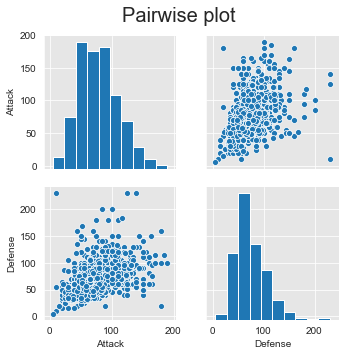

,Attack,Defense
Attack,1.000000,0.514995
Defense,0.514995,1.000000


In [15]:
pairwise_plot(pokemons[['Attack', 'Defense']])

**Spearman correlation** is 0.51 and we visualize the relationship with a pairwise plot. We cannot say that there is correlation. Maybe if we looked at the correlation between both with respect to each class we could observe some correlation.

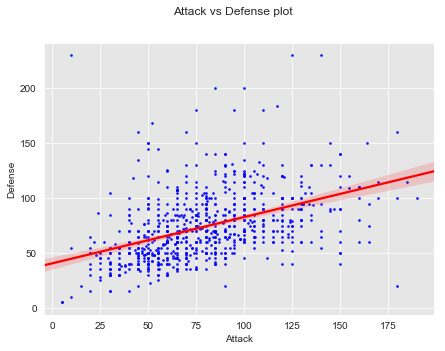

Pearson correlation coefficient is: 0.44   

Spearman correlation coefficient is: 0.51   



(0.4386870551184902, 0.5149946056788182)

In [16]:
regression_plot(pokemons[['Attack', 'Defense']], 'Attack', 'Defense', 'Attack vs Defense plot')

In [17]:
# list the names of the 3 Pokémon with highest attack-over-defense ratio;
pokemons_copy = pokemons.copy()
pokemons_copy['attack_defense_ratio']=pokemons_copy['Attack']/pokemons_copy['Defense']
pokemons_copy.sort_values(by='attack_defense_ratio', ascending=False).head(3).Name

pid
430    DeoxysAttack Forme
348              Carvanha
20          Mega Beedrill
Name: Name, dtype: object

In [18]:
# list the names of the 3 Pokémon with lowest attack-over-defense ratio;
pokemons_copy = pokemons.copy()
pokemons_copy['attack_defense_ratio']=pokemons_copy['Attack']/pokemons_copy['Defense']
pokemons_copy.sort_values(by='attack_defense_ratio', ascending=True).head(3).Name

pid
231     Shuckle
140    Magikarp
485     Bronzor
Name: Name, dtype: object

In [19]:
# list the names of the 10 Pokémon with the largest number of victories
victories = combats['Winner'].value_counts(normalize=False, ascending=False, sort=True).head(10)
pokemons_copy.loc[victories.index].Name

163                Mewtwo
154            Aerodactyl
438             Infernape
428               Jirachi
432    Deoxys Speed Forme
314               Slaking
214               Murkrow
394            Mega Absol
249         Mega Houndoom
155       Mega Aerodactyl
Name: Name, dtype: object

In [20]:
pokemons_copy.loc[victories.index]

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,attack_defense_ratio
163,Mewtwo,Psychic,NaN,106,110,90,154,90,130,True,1.222222
154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,False,1.615385
438,Infernape,Fire,Fighting,76,104,71,104,71,108,False,1.464789
428,Jirachi,Steel,Psychic,100,100,100,100,100,100,True,1.000000
432,Deoxys Speed Forme,Psychic,NaN,50,95,90,95,90,180,True,1.055556
314,Slaking,Normal,NaN,150,160,100,95,65,100,False,1.600000
214,Murkrow,Dark,Flying,60,85,42,85,42,91,False,2.023810
394,Mega Absol,Dark,NaN,65,150,60,115,60,115,False,2.500000
249,Mega Houndoom,Dark,Fire,75,90,90,140,90,115,False,1.000000
155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,False,1.588235


**Pokemons with largest number of victories** do not correspond to highest attack over defense ratio. 

#### (10 points) Professor Oak suspects that Pokémon in the grass class have a stronger regular attack than those in the rock class. Check if he is right and convince him of your conclusion with statistical arguments. Note: If there are Pokémon that are in both classes, discard them. Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.

In [21]:
# drops pokemons that have both classes 
pokemons_copy.drop(pokemons_copy[
    (pokemons_copy['Class 1'] == 'Grass') & (pokemons_copy['Class 2'] == 'Rock')].index, axis=0, inplace=True)

pokemons_copy.drop(pokemons_copy[
    (pokemons_copy['Class 2'] == 'Grass') & (pokemons_copy['Class 1'] == 'Rock')].index, axis=0, inplace=True)

# isolate specific classes 
pokemons_grass = pokemons_copy[(pokemons_copy['Class 1'] == 'Grass') | (pokemons_copy['Class 2'] == 'Grass')]
pokemons_rock = pokemons_copy[(pokemons_copy['Class 1'] == 'Rock') | (pokemons_copy['Class 2'] == 'Rock')]

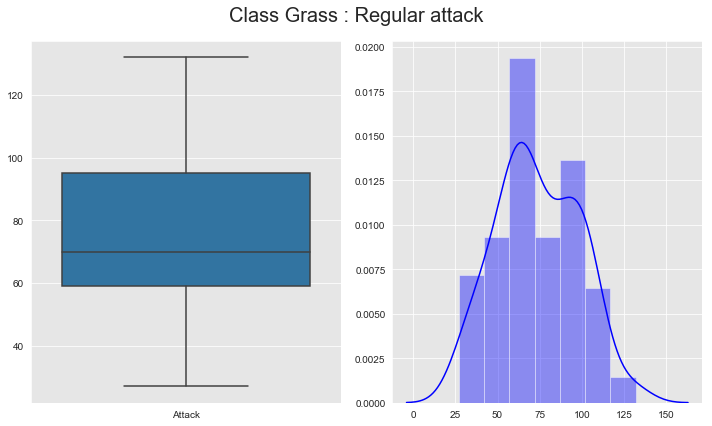

,count,mean,std,min,25%,50%,75%,max
Attack,93.0,73.731183,24.179645,27.0,59.0,70.0,95.0,132.0


In [22]:
# describe for class grass
describe_data(pokemons_grass['Attack'], 'Class Grass : Regular attack')

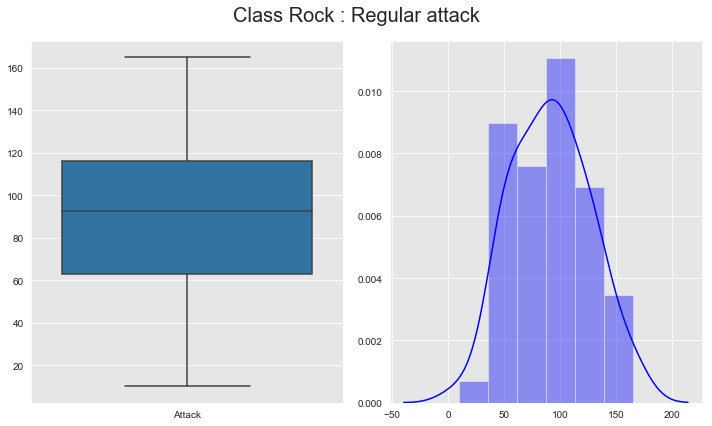

,count,mean,std,min,25%,50%,75%,max
Attack,56.0,91.785714,34.805284,10.0,63.0,92.5,116.25,165.0


In [23]:
# describe for class rock
describe_data(pokemons_rock['Attack'], 'Class Rock : Regular attack')

**Rock class**: attack mean is at 91.79 and median is at 92.5. It seems to have a stronger attack than class grass at first approach because for class grass: attack mean is at 73.73 and median is at 70.0. To reassure Professor Oak, let's conduct a Welch t-test! Standard deviation is 24.18 for grass class and 34.81 for rock glass. Since they are slightly different we conduct a Welch t-test with unequal variance.

In [24]:
scipy.stats.ttest_ind(pokemons_rock['Attack'], pokemons_grass['Attack'], equal_var = False)

Ttest_indResult(statistic=3.4169379582521513, pvalue=0.0009640546913545304)

**At a significance level of 0.01, pvalue of 0.00096, pokemons from class rock seem to have a stronger attack than from class grass.**

In [25]:
# since they don't have the same number of samples: we subsample the grass class 
subsample_grass_class = pokemons_grass.sample(n=pokemons_rock.shape[0])
scipy.stats.ttest_ind(pokemons_rock['Attack'], subsample_grass_class['Attack'], equal_var = False)


Ttest_indResult(statistic=3.8443673802601173, pvalue=0.0002169971269626024)

In [26]:
scipy.stats.f_oneway(pokemons_rock['Attack'], pokemons_grass['Attack'])

F_onewayResult(statistic=13.908853861099336, pvalue=0.00027333381459902556)

#### (10 points) Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories. Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called pokemon and combats, with the same schema as the small CSV files you’ve been working with above.

# Problem 2
#### (3 points) Generate the feature vectors and the labels to train your model.

In [27]:
pokemons_ML = pokemons.copy()
combats_ML = combats.copy()
pokemons_ML.drop(labels=['Class 2', 'Name'], axis=1, inplace=True)
pokemons_ML.head()

,Class 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
pid,,,,,,,,
1,Grass,45,49,49,65,65,45,False
2,Grass,60,62,63,80,80,60,False
3,Grass,80,82,83,100,100,80,False
4,Grass,80,100,123,122,120,80,False
5,Fire,39,52,43,60,50,65,False


In [28]:
# convert boolean to categorical to 0,1 
pokemons_ML['Legendary'] = (pokemons_ML['Legendary'] == True).astype(np.uint8)

In [29]:
combats_ML_poke1 = combats_ML.merge(
    pokemons_ML,how='inner',left_on='First_pokemon', right_on=pokemons_ML.index)
combats_ML_poke1.head()

,First_pokemon,Second_pokemon,Winner,Class 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,266,298,298,Rock,50,64,50,45,50,41,0
1,266,301,301,Rock,50,64,50,45,50,41,0
2,266,304,266,Rock,50,64,50,45,50,41,0
3,266,247,247,Rock,50,64,50,45,50,41,0
4,266,690,690,Rock,50,64,50,45,50,41,0


In [30]:
pokemons_ML.shape

(800, 8)

In [31]:
combats_ML_poke1_poke2 = combats_ML_poke1.merge(
    pokemons_ML, how='inner',left_on='Second_pokemon', right_on=pokemons_ML.index, suffixes=('_poke1', '_poke2'))
combats_ML_poke1_poke2.head()

,First_pokemon,Second_pokemon,Winner,Class 1_poke1,HP_poke1,Attack_poke1,Defense_poke1,Sp. Atk_poke1,Sp. Def_poke1,Speed_poke1,Legendary_poke1,Class 1_poke2,HP_poke2,Attack_poke2,Defense_poke2,Sp. Atk_poke2,Sp. Def_poke2,Speed_poke2,Legendary_poke2
0,266,298,298,Rock,50,64,50,45,50,41,0,Grass,70,70,40,60,40,60,0
1,73,298,298,Fighting,70,80,50,35,35,35,0,Grass,70,70,40,60,40,60,0
2,373,298,298,Water,110,78,73,76,71,60,0,Grass,70,70,40,60,40,60,0
3,536,298,536,Electric,50,65,107,105,107,86,0,Grass,70,70,40,60,40,60,0
4,368,298,368,Normal,73,115,60,60,60,90,0,Grass,70,70,40,60,40,60,0


In [32]:
combats_ML_poke1_poke2['label'] = np.where(
    combats_ML_poke1_poke2['Winner']==combats_ML_poke1_poke2['First_pokemon'], 1,0)
combats_ML_poke1_poke2.head()

,First_pokemon,Second_pokemon,Winner,Class 1_poke1,HP_poke1,Attack_poke1,Defense_poke1,Sp. Atk_poke1,Sp. Def_poke1,Speed_poke1,Legendary_poke1,Class 1_poke2,HP_poke2,Attack_poke2,Defense_poke2,Sp. Atk_poke2,Sp. Def_poke2,Speed_poke2,Legendary_poke2,label
0,266,298,298,Rock,50,64,50,45,50,41,0,Grass,70,70,40,60,40,60,0,0
1,73,298,298,Fighting,70,80,50,35,35,35,0,Grass,70,70,40,60,40,60,0,0
2,373,298,298,Water,110,78,73,76,71,60,0,Grass,70,70,40,60,40,60,0,0
3,536,298,536,Electric,50,65,107,105,107,86,0,Grass,70,70,40,60,40,60,0,1
4,368,298,368,Normal,73,115,60,60,60,90,0,Grass,70,70,40,60,40,60,0,1


In [33]:
labels = combats_ML_poke1_poke2['label']
features = combats_ML_poke1_poke2.copy()
features.drop(labels=['label','Winner', 'First_pokemon', 'Second_pokemon'],axis=1, inplace=True)

In [34]:
# Then you can assign the encoded variable to a new column using the cat.codes accessor:
features['Class 1_poke1'] = features['Class 1_poke1'].astype('category').cat.codes
features['Class 1_poke2'] = features['Class 1_poke2'].astype('category').cat.codes
features.head()

,Class 1_poke1,HP_poke1,Attack_poke1,Defense_poke1,Sp. Atk_poke1,Sp. Def_poke1,Speed_poke1,Legendary_poke1,Class 1_poke2,HP_poke2,Attack_poke2,Defense_poke2,Sp. Atk_poke2,Sp. Def_poke2,Speed_poke2,Legendary_poke2
0,15,50,64,50,45,50,41,0,9,70,70,40,60,40,60,0
1,5,70,80,50,35,35,35,0,9,70,70,40,60,40,60,0
2,17,110,78,73,76,71,60,0,9,70,70,40,60,40,60,0
3,3,50,65,107,105,107,86,0,9,70,70,40,60,40,60,0
4,12,73,115,60,60,60,90,0,9,70,70,40,60,40,60,0


#### (5 points) How does your model handle categorical features and Pokémon with multiple classes?

Class 2 has mutliple nan values. I discard class 2.

#### (10 points) Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (n_estimators, try values 10, 25, 50, 100) and the maximum tree depth (max_depth, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.

In [35]:
def split_data(x, y, ratio, myseed=1):
    """
    x, y must be arrays
    Split the dataset based on the given ratio.
    Give train, labels, ratio (arrays: if data frame do df.values)
    Returns train, test, y_train, y_test arrays
    """
    # check input are arrays
    check_array(x)
    check_array(y)
    # set seed
    np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

def check_array(array: np.array) -> None:
    if not isinstance(array, np.ndarray):
        raise TypeError('array must be an array not a {}'.format(type(array)))

In [36]:
features.shape

(50000, 16)

In [37]:
X_train, X_test, y_train, y_test = split_data(features.values, labels.values, ratio=0.9)

In [41]:
def clf_evaluation(clf, x_train, y_train, x_test, y_test):
    """ Evaluate the random forest given training and testing sets"""
    print('Evaluate classifier: train the model and predict')
    clf.fit(x_train, y_train)  # fit the model
    correctness: list = clf.predict(x_test) == y_test
    return sum(correctness)/len(correctness)  # accuracy


def check_array(array: np.array) -> None:
    if not isinstance(array, np.ndarray):
        raise TypeError('array must be an array not a {}'.format(type(array)))

        
def grid_search_RF_noCV(X, y, num_depth, num_trees, plot_heatmap=True):
    """ Grid search using CV with random forest. X, y must be arrays """
    # check input are arrays
    check_array(X)
    check_array(y)
    accuracy = np.zeros(len(num_depth) * len(num_trees))  # accuracy array

    ct = 0  # counter
    print('Start grid search')
    for n_depth in num_depth:
        for n_trees in num_trees:
            print('\n Try param {} and {}, {}'.format(n_trees, n_depth, strftime("%H:%M:%S", gmtime())))
            # for each grid, define a random forest and evaluate the forest using crossvalidation
            RForest = RandomForestClassifier(n_estimators=n_trees, max_depth=n_depth)
            accuracy[ct] = clf_evaluation(RForest, X, y, X, y)
            ct += 1

    accuracy = accuracy.reshape(len(num_depth), len(num_trees))
    ind = np.unravel_index(np.argmax(accuracy, axis=None), accuracy.shape)
    best_hyperparameters = {
        'max_accuracy': accuracy[ind],
        'best_depth': num_depth[ind[0]],
        'best_tree': num_trees[ind[1]]
    }
    print("\n Best hyperparameters are: best_depth: {} n_estimators (trees) : {}".format(
        num_depth[ind[0]], num_trees[ind[1]])
    )
    if plot_heatmap:
        plot_results_RF(accuracy, num_depth, num_trees)
    return best_hyperparameters


def plot_results_RF(accuracy, grid_params1, grid_params2) -> None:
    """ Plot heat map of the results of the grid search"""
    # plot the result of grid search
    plt.figure(figsize=(8, 6))
    ax1 = sns.heatmap(
        accuracy,
        vmin=np.min(accuracy),  # vmin = 0.8,
        vmax=np.max(accuracy),  # vmax = 0.86
        cmap="YlGnBu",
        xticklabels=grid_params2,
        yticklabels=grid_params1
    )

    plt.title('accuracy distribution', fontsize=14)
    plt.xlabel('the number of trees', fontsize=14)
    plt.ylabel('depth', fontsize=14)
    plt.show()

    print('cross-validation accuracy of {:.2f}'.format(accuracy.max()*100))

Start grid search

 Try param 10 and 2, 13:42:23
Evaluate classifier: train the model and predict

 Try param 25 and 2, 13:42:24
Evaluate classifier: train the model and predict

 Try param 50 and 2, 13:42:26
Evaluate classifier: train the model and predict

 Try param 100 and 2, 13:42:29
Evaluate classifier: train the model and predict

 Try param 10 and 4, 13:42:34
Evaluate classifier: train the model and predict

 Try param 25 and 4, 13:42:35
Evaluate classifier: train the model and predict

 Try param 50 and 4, 13:42:37
Evaluate classifier: train the model and predict

 Try param 100 and 4, 13:42:41
Evaluate classifier: train the model and predict

 Try param 10 and 10, 13:42:48
Evaluate classifier: train the model and predict

 Try param 25 and 10, 13:42:50
Evaluate classifier: train the model and predict

 Try param 50 and 10, 13:42:54
Evaluate classifier: train the model and predict

 Try param 100 and 10, 13:43:01
Evaluate classifier: train the model and predict

 Best hyperpar

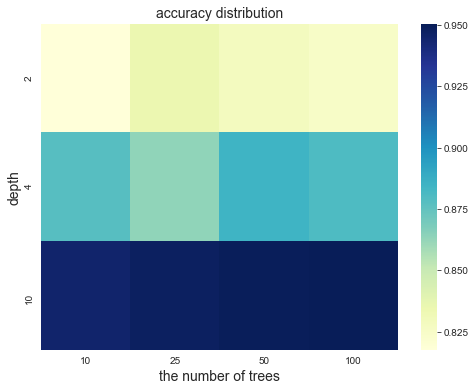

cross-validation accuracy of 95.06


{'max_accuracy': 0.9505777777777777, 'best_depth': 10, 'best_tree': 100}

In [42]:
n_estimators = [10, 25, 50, 100]
max_depth = [2, 4, 10]
grid_search_RF_noCV(X_train, y_train, num_depth=max_depth, num_trees=n_estimators, plot_heatmap=True)

#### (5 points) Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?

**Best hyperparameters**: `best max depth`: 10, `best n_estimators`: 10

#### (5 points) Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).

Yes we are **overfitting** because grid search directly on the training set: solution use **k-fold CV** to have **unbiased** estimation of the generalisation error.

#### (7 points) Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.

In [43]:
def my_cross_validation(X, y, clf, k_fold, ratio, seed):
    """ Evaluate the accuracy using cross-validating """
    pred_ratio = []
    # iterate through each train-test split
    print('Start cross validation {}'.format(strftime("%H:%M:%S", gmtime())))
    for k in range(k_fold):
        x_train, x_test, y_train, y_test = split_data(X, y, ratio, seed) # the k-th split
        accuracy = clf_evaluation(clf, x_train, y_train, x_test, y_test) # evaluate the result
        pred_ratio.append(accuracy)
        if k == k_fold/2:
            print('{} fold, 50% of CV done, {}'.format(k, strftime("%H:%M:%S", gmtime())))
    return np.mean(pred_ratio)


def grid_search_RF(X, y, k_fold, num_depth, num_trees, plot_heatmap=True, rand_seed=1, tt_ratio=0.5):
    """ Grid search using CV with random forest. X, y must be arrays """
    # check input are arrays
    check_array(X)
    check_array(y)
    accuracy = np.zeros(len(num_depth) * len(num_trees))  # accuracy array

    ct = 0  # counter
    print('Start grid search')
    for n_depth in num_depth:
        for n_trees in num_trees:
            print('\n Try param {} and {}, {}'.format(n_trees, n_depth, strftime("%H:%M:%S", gmtime())))
            # for each grid, define a random forest and evaluate the forest using crossvalidation
            RForest = RandomForestClassifier(n_estimators=n_trees, max_depth=n_depth)
            accuracy[ct] = my_cross_validation(X, y, RForest, k_fold, tt_ratio, rand_seed)
            ct += 1

    accuracy = accuracy.reshape(len(num_depth), len(num_trees))
    ind = np.unravel_index(np.argmax(accuracy, axis=None), accuracy.shape)
    best_hyperparameters = {
        'max_accuracy': accuracy[ind],
        'best_depth': num_depth[ind[0]],
        'best_tree': num_trees[ind[1]]
    }
    print("Best hyperparameters are: best_depth: {} n_estimators (trees) : {}".format(
        num_depth[ind[0]],
        num_trees[ind[1]])
    )
    if plot_heatmap:
        plot_results_RF(accuracy, num_depth, num_trees)
    return best_hyperparameters

Start grid search

 Try param 10 and 2, 13:43:39
Start cross validation 13:43:39
Evaluate classifier: train the model and predict
Evaluate classifier: train the model and predict
1 fold, 50% of CV done, 13:43:41

 Try param 25 and 2, 13:43:41
Start cross validation 13:43:41
Evaluate classifier: train the model and predict
Evaluate classifier: train the model and predict
1 fold, 50% of CV done, 13:43:43

 Try param 50 and 2, 13:43:43
Start cross validation 13:43:43
Evaluate classifier: train the model and predict
Evaluate classifier: train the model and predict
1 fold, 50% of CV done, 13:43:47

 Try param 100 and 2, 13:43:47
Start cross validation 13:43:47
Evaluate classifier: train the model and predict
Evaluate classifier: train the model and predict
1 fold, 50% of CV done, 13:43:53

 Try param 10 and 4, 13:43:53
Start cross validation 13:43:53
Evaluate classifier: train the model and predict
Evaluate classifier: train the model and predict
1 fold, 50% of CV done, 13:43:56

 Try param

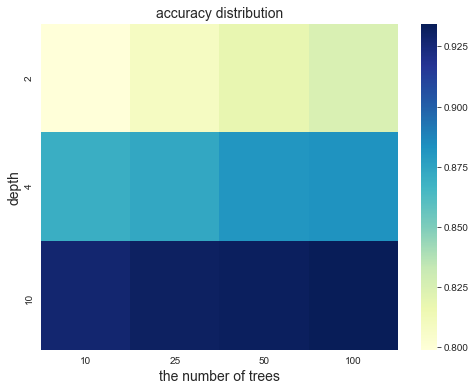

cross-validation accuracy of 93.44


{'max_accuracy': 0.9344444444444444, 'best_depth': 10, 'best_tree': 100}

In [44]:
grid_search_RF(X_train, y_train, k_fold=2, num_depth=max_depth, num_trees=n_estimators, plot_heatmap=True)

Still a bit of overfitting because of the training set/testing set at 90%, but the accuracy dropped a bit.

#### (5 points) Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

In [45]:
# retrain and predict with best hp found by grid search CV
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

accuracy = sum(y_test == y_hat)/y_test.shape[0]

print(accuracy)

0.9344


In [46]:
def plot_features_importance(clf: RandomForestClassifier, X: pd.DataFrame) -> None:
    """ Plot feature importance per Random Forest Classifier.
    :param clf: RandomForestClassifier fitted
    :param X: X is the train data, with all columns used to fit the RF.
    :return: None
    """
    check_dataframe(X)
    forest_feature_imp = pd.Series(
        clf.feature_importances_,
        index=X.columns)\
        .sort_values(ascending=False)

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    sns.barplot(x=forest_feature_imp, y=forest_feature_imp.index, ax=ax)
    # Add labels
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important features with {} score".format(clf.criterion))
    plt.show()

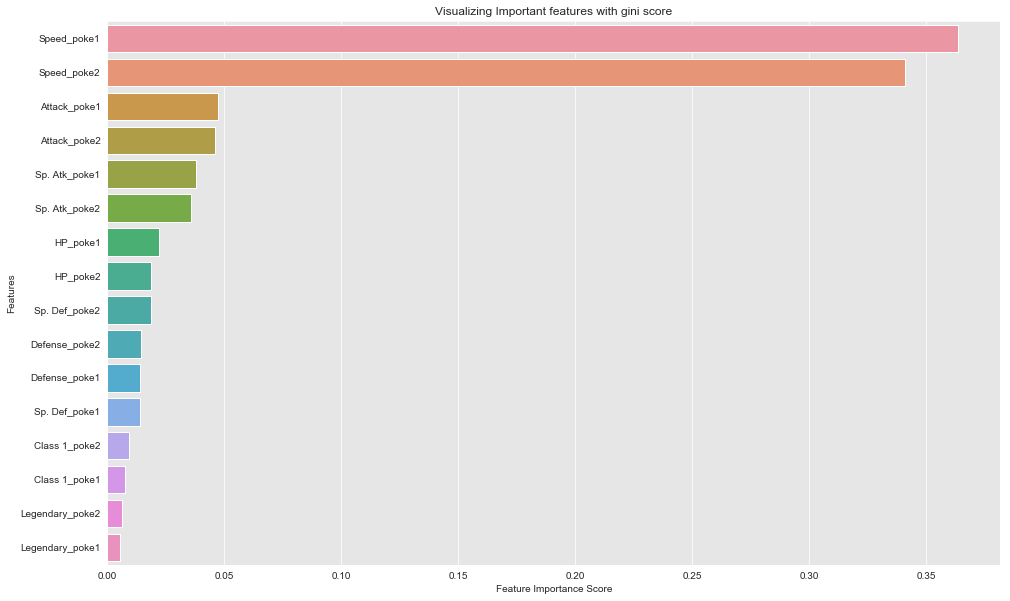

In [47]:
plot_features_importance(clf, features)

# Problem 3
#### (5 points) Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

In [78]:
victories = pd.DataFrame(data=combats.Winner.value_counts(), 
                         index=combats.Winner.value_counts().index)
victories.head()

,Winner
163,152
154,136
438,136
428,134
432,133


In [79]:
# nb of match
# flatten the First pokemon and second_pokemon
flatten_comb_pokes = pd.Series(
    data=combats[['First_pokemon', 'Second_pokemon']].values.flatten())
print(flatten_comb_pokes.head())
print('\n')
# count values
matches = pd.DataFrame(
    data=flatten_comb_pokes.value_counts(), 
    index=flatten_comb_pokes.value_counts().index, columns=['matches']
)
print(matches.head())

0    266
1    298
2    702
3    701
4    191
dtype: int64


     matches
163      164
344      160
667      159
214      158
758      158


In [82]:
matches_victories = matches.merge(
    victories, 
    how='inner', 
    left_index=True, 
    right_index=True, 
    validate='one_to_one'
)

In [83]:
matches_victories.head()

,matches,Winner
163,164,152
344,160,104
667,159,21
214,158,130
758,158,108


In [86]:
matches_victories['ratio'] = matches_victories.Winner/ matches_victories.matches
matches_victories.head()

,matches,Winner,ratio
163,164,152,0.926829
344,160,104,0.650000
667,159,21,0.132075
214,158,130,0.822785
758,158,108,0.683544


In [92]:
# top winners
pokemons.loc[matches_victories.sort_values(by='ratio', ascending=False).head(10).index].Name

155             Mega Aerodactyl
513                     Weavile
704      Tornadus Therian Forme
20                Mega Beedrill
154                  Aerodactyl
477                Mega Lopunny
727                    Greninja
717    Meloetta Pirouette Forme
165               Mega Mewtwo Y
350               Mega Sharpedo
Name: Name, dtype: object

In [107]:
top10_winners = pokemons.loc[matches_victories.sort_values(by='ratio', ascending=False).head(10).index]
top10_winners = top10_winners.merge(
    matches_victories,
    how='inner', right_index=True, left_index=True
)
top10_winners

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,matches,Winner,ratio
155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,False,129,127,0.984496
513,Weavile,Dark,Ice,70,120,65,45,85,125,False,119,116,0.974790
704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,True,125,121,0.968000
20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,False,119,115,0.966387
154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,False,141,136,0.964539
477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,False,129,124,0.961240
727,Greninja,Water,Dark,72,95,67,103,71,122,False,127,122,0.960630
717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,False,123,118,0.959350
165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,True,125,119,0.952000
350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,False,120,114,0.950000


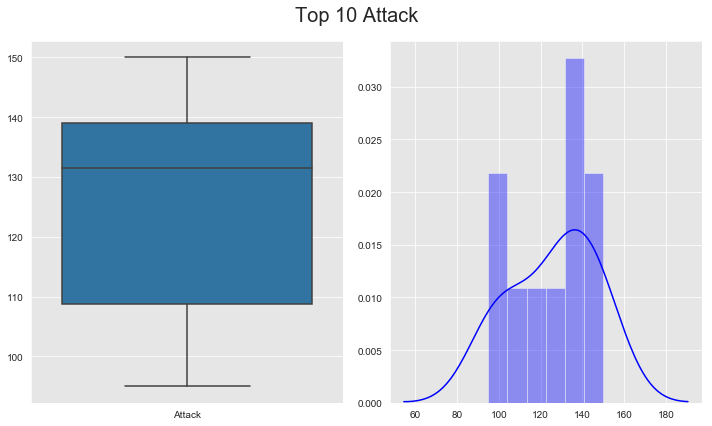

,count,mean,std,min,25%,50%,75%,max
Attack,10.0,125.9,20.129856,95.0,108.75,131.5,139.0,150.0


In [101]:
describe_data(top10_winners.Attack, title='Top 10 Attack', nb_bins=6)

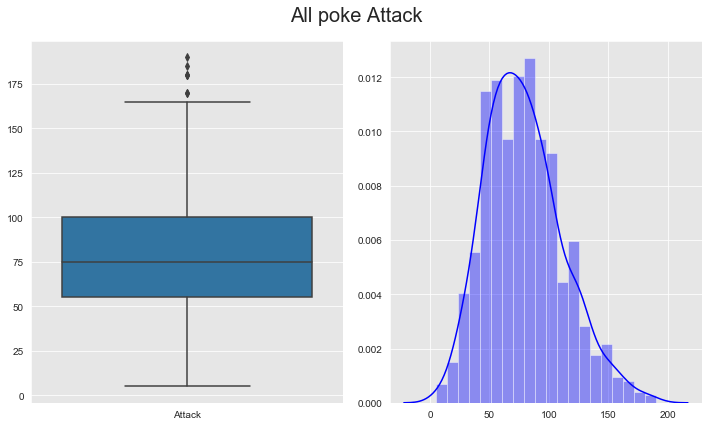

,count,mean,std,min,25%,50%,75%,max
Attack,800.0,79.00125,32.457366,5.0,55.0,75.0,100.0,190.0


In [97]:
describe_data(pokemons.Attack, title='All poke Attack')

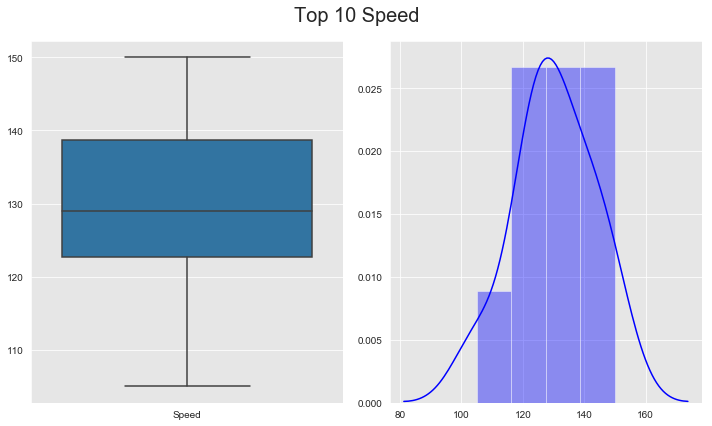

,count,mean,std,min,25%,50%,75%,max
Speed,10.0,130.1,13.118689,105.0,122.75,129.0,138.75,150.0


In [98]:
describe_data(top10_winners.Speed, title='Top 10 Speed')

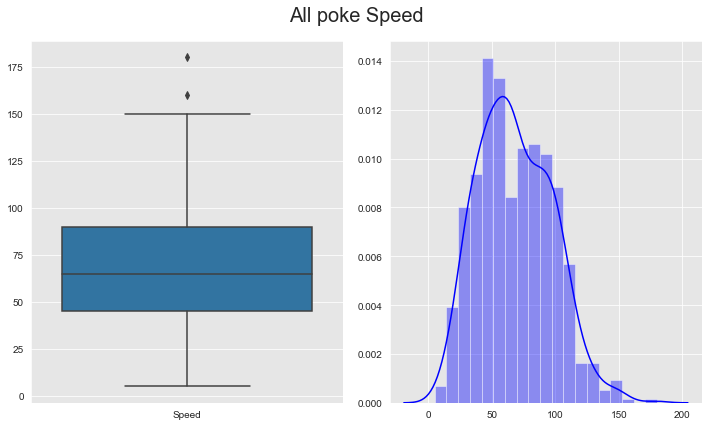

,count,mean,std,min,25%,50%,75%,max
Speed,800.0,68.2775,29.060474,5.0,45.0,65.0,90.0,180.0


In [99]:
describe_data(pokemons.Speed, title='All poke Speed')

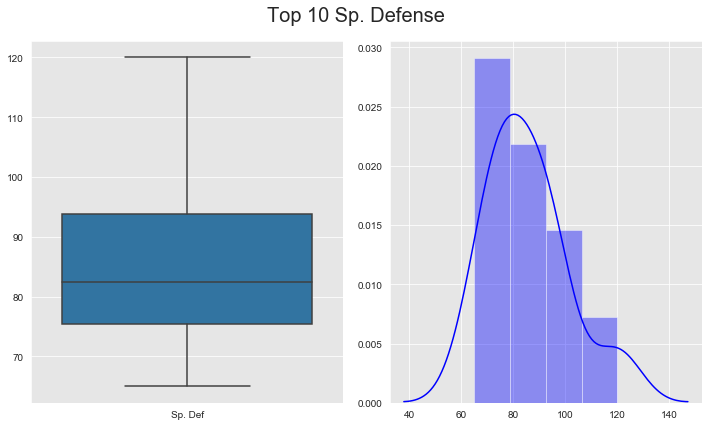

,count,mean,std,min,25%,50%,75%,max
Sp. Def,10.0,85.4,15.826841,65.0,75.5,82.5,93.75,120.0


In [115]:
describe_data(top10_winners['Sp. Def'], title='Top 10 Sp. Defense')

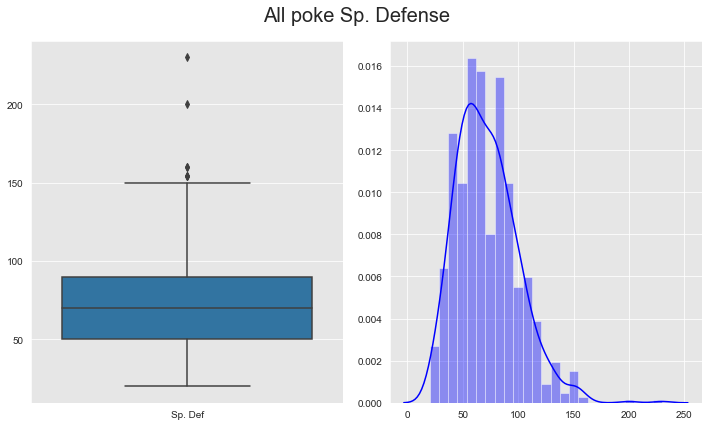

,count,mean,std,min,25%,50%,75%,max
Sp. Def,800.0,71.9025,27.828916,20.0,50.0,70.0,90.0,230.0


In [114]:
describe_data(pokemons['Sp. Def'], title='All poke Sp. Defense')

**Conclusion.** Speed and attack seem the most relevant features, as in random forest. They are both very high in the top 10 winners subgroup, compared to whole pokemon populations.

#### Pokémon tournaments can be represented as a so-called dominance graph. The dominance graph is a directed graph in which each Pokémon is represented by one vertex, and directed edges point from stronger to weaker Pokémons: in particular, if Pokémon i has won a strictly larger number of times against Pokémon j than j has won against i (that is, if i dominates j), there is a directed edge pointing from node i to node j. The dominance graph can be represented as an adjacency matrix G where entry Gij is 1 if there is an edge pointing from i to j, and 0 otherwise.

#### (10 points) A simple method for identifying the strongest Pokémon using this graph is to compute the matrix A = G + G2. Consider a given row of A; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.

In [152]:
winner_losers = combats.copy()
winner_losers['Loser'] = combats['First_pokemon'].where(
    winner_losers['Winner'] == winner_losers['Second_pokemon'], 
    winner_losers['Second_pokemon']
)

adjacent_matrix = winner_losers.groupby(by=['Winner', 'Loser']).size().unstack(level=-1)
adjacent_matrix.fillna(value=0, inplace=True)
adjacent_matrix.head()

Loser,1,2,3,4,5,6,7,8,9,10,...,791,792,793,794,795,796,797,798,799,800
Winner,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [167]:
# this pokemon loses all matches
adjacent_matrix.drop(
    labels=set(adjacent_matrix.columns.values) - set(adjacent_matrix.index.values),
    axis=1, inplace=True
)

In [157]:
np.where(adjacent_matrix.values > adjacent_matrix.values.T, 1, 0)

ValueError: operands could not be broadcast together with shapes (783,784) (784,783) 

In [160]:
# find G
pd.DataFrame(data=adjacent_matrix.where(adjacent_matrix.values > adjacent_matrix.values.T, 1, 0), 
             index=adjacent_matrix.index,
             columns=adjacent_matrix.columns
            )

ValueError: operands could not be broadcast together with shapes (783,784) (784,783) 

In [125]:
combats.groupby().agg()

(50000, 3)

In [120]:
adjacent_matrix(combats)

0    298
1    701
2    668
3    683
4    151
Name: Winner, dtype: int64
0    266
1    702
2    191
3    237
4    151
Name: First_pokemon, dtype: int64


In [121]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


#### (7 points) Compute A and extract the 10 Pokémon with the highest dominance score.

#### (3 points) Compare the ranking by dominance scores with the ranking by winning ratio (cf. subquestion 1 above). What do you observe? How do you explain the differences (if any)?

#### (5 points) Professor Oak is really keen on featuring a solid ranking mechanism in the new Pokedex, so you need to make a decision: Which scoring method is better, that based on winning ratio or that based on dominance scores? Support your opinion with explanations and examples.